Split data -> SMOTE+RU

In [1]:
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Load features and raw labels
X = np.load('preprocessed_data/X_all_normalized.npy')

with open('preprocessed_data/sym_all.pkl', 'rb') as f:
    y_raw = pickle.load(f)

# Encode labels (string → integer)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

print("Original class distribution:", Counter(y))

Original class distribution: Counter({6: 74795, 5: 8052, 7: 7235, 9: 7113, 0: 6999, 1: 2536, 12: 982, 3: 801, 13: 229, 10: 150, 2: 106, 4: 83, 11: 16, 8: 2})


In [2]:
from sklearn.model_selection import train_test_split

# 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train class distribution:", Counter(y_train))
print("Test class distribution (untouched):", Counter(y_test))

Train class distribution: Counter({6: 59836, 5: 6441, 7: 5788, 9: 5690, 0: 5599, 1: 2029, 12: 786, 3: 641, 13: 183, 10: 120, 2: 85, 4: 66, 11: 13, 8: 2})
Test class distribution (untouched): Counter({6: 14959, 5: 1611, 7: 1447, 9: 1423, 0: 1400, 1: 507, 12: 196, 3: 160, 13: 46, 10: 30, 2: 21, 4: 17, 11: 3})


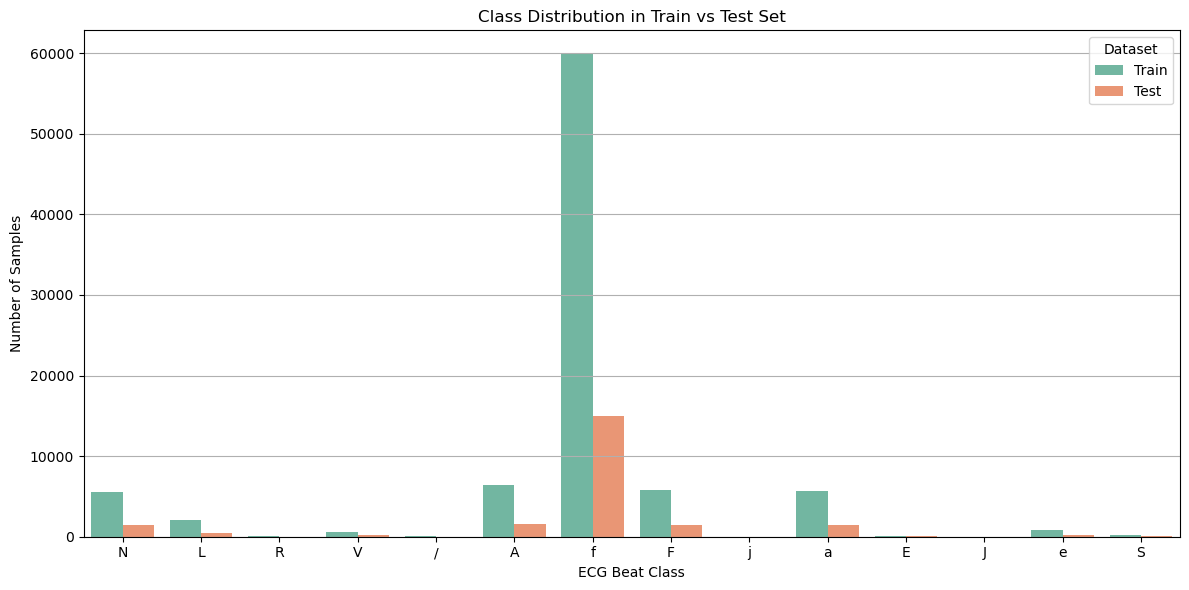

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Label mapping from encoded integers to ECG symbols
ECG_classes = ['N', 'L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']

# Your provided counts
train_counter = {6: 59836, 5: 6441, 7: 5788, 9: 5690, 0: 5599, 1: 2029, 12: 786, 3: 641,
                 13: 183, 10: 120, 2: 85, 4: 66, 11: 13, 8: 2}
test_counter  = {6: 14959, 5: 1611, 7: 1447, 9: 1423, 0: 1400, 1: 507, 12: 196, 3: 160,
                 13: 46, 10: 30, 2: 21, 4: 17, 11: 3}

# Sorted class indices
all_classes = sorted(set(train_counter.keys()) | set(test_counter.keys()))
class_labels = [ECG_classes[i] for i in all_classes]

# Construct data for DataFrame
data = {
    'Class': class_labels * 2,
    'Count': [train_counter.get(i, 0) for i in all_classes] + [test_counter.get(i, 0) for i in all_classes],
    'Dataset': ['Train'] * len(all_classes) + ['Test'] * len(all_classes)
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df, palette='Set2')
plt.title('Class Distribution in Train vs Test Set')
plt.xlabel('ECG Beat Class')
plt.ylabel('Number of Samples')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np

# Handle rare class (e.g. class 8) manually
rare_class = 8
rare_mask = (y_train == rare_class)
X_rare = X_train[rare_mask]
y_rare = y_train[rare_mask]

# Manually oversample rare class to 8000
X_rare_oversampled = np.tile(X_rare, (8000 // len(X_rare), 1))
y_rare_oversampled = np.tile(y_rare, (8000 // len(y_rare),))
remaining = 8000 - len(X_rare_oversampled)
if remaining > 0:
    idx = np.random.choice(len(X_rare), remaining)
    X_rare_oversampled = np.vstack([X_rare_oversampled, X_rare[idx]])
    y_rare_oversampled = np.hstack([y_rare_oversampled, y_rare[idx]])

# Filter valid classes
threshold = 10
class_counts = Counter(y_train)
valid_classes = [cls for cls, count in class_counts.items() if count >= threshold and cls != rare_class]

mask = np.isin(y_train, valid_classes)
X_train_filtered = X_train[mask]
y_train_filtered = y_train[mask]

# Resample with SMOTE + RU
target_samples_per_class = 8000
sampling_strategy = {cls: target_samples_per_class for cls in valid_classes}

pipeline = Pipeline(steps=[
    ('smote', SMOTE(sampling_strategy='not majority', random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42))
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_filtered, y_train_filtered)

# Combine with rare class
X_train_final = np.vstack((X_resampled, X_rare_oversampled))
y_train_final = np.hstack((y_resampled, y_rare_oversampled))

print("Final train class distribution:", Counter(y_train_final))

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.u

Final train class distribution: Counter({0: 8000, 1: 8000, 2: 8000, 3: 8000, 4: 8000, 5: 8000, 6: 8000, 7: 8000, 9: 8000, 10: 8000, 11: 8000, 12: 8000, 13: 8000, 8: 8000})


In [5]:
from tensorflow.keras.utils import to_categorical

# Reshape for Conv1D
X_train_final = X_train_final[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# One-hot encode labels
y_train_cat = to_categorical(y_train_final, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train_final.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-07 21:18:41.824176: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-07 21:18:41.824207: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-07 21:18:41.824211: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-07 21:18:41.824350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-07 21:18:41.824360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2154, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1077, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1073, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 536, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 534, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 267, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 68352)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,749,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,891,150 (33.92 MB)

 Trainable params: 8,891,150 (33.92 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(
    X_train_final, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=10,
    batch_size=64
)

Epoch 1/10


2025-05-07 21:18:42.794952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 106s 60ms/step - accuracy: 0.4599 - loss: 1.6940 - val_accuracy: 0.7445 - val_loss: 0.9931
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 103s 59ms/step - accuracy: 0.8691 - loss: 0.5874 - val_accuracy: 0.8421 - val_loss: 0.7761
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 103s 59ms/step - accuracy: 0.8844 - loss: 0.6853 - val_accuracy: 0.8475 - val_loss: 1.3438
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 103s 59ms/step - accuracy: 0.8916 - loss: 1.0603 - val_accuracy: 0.9034 - val_loss: 1.5266
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 103s 59ms/step - accuracy: 0.8964 - loss: 1.8466 - val_accuracy: 0.8239 - val_loss: 5.7377
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 103s 59ms/step - accuracy: 0.9039 - loss: 3.3089 - val_accuracy: 0.9064 - val_loss: 5.3364
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 104s 59ms/step - accuracy: 0.9119 - loss: 5.1831 - val_accuracy: 0.9199 - val_loss: 7.5253
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 102s 58ms/step - accuracy: 0.9160 - lo